In [6]:
from tables import open_file
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from scipy.ndimage import sobel
from matplotlib import cm

# Step 1: Read the HDF5 File  
In this step, we will:
1. Open the HDF5 file and extract the image data into `ImagesTable`.
2. Find the size (height and width) of the first image to understand the image dimensions.
3. Flatten all the images into 1D arrays so they can be processed numerically.
4. Display the first 2 images to visualize them.

After this step, the output will be:
- The image dimensions (height and width)
- The flattened images, which will be used for further processing

In [8]:
def process_and_plot_images(datafilename):
    ImagesFile = open_file(datafilename, mode="r")
    ImagesTable = ImagesFile.root.Images.Images
    
    first_image = next(ImagesTable.iterrows())['image']
    image_height, image_width = first_image.shape
    
    length = image_height * image_width
    flattened_images = np.zeros((ImagesTable.nrows, length))
    
    for i, image_row in enumerate(ImagesTable.iterrows()):
        flattened_images[i] = image_row['image'].flatten()
    
    for i in range(2):
        plt.matshow(flattened_images[i].reshape(image_height, image_width))
        plt.title(f"{datafilename} - Image {i+1}")
        plt.show()

    ImagesFile.close()
    
    return image_height, image_width, flattened_images

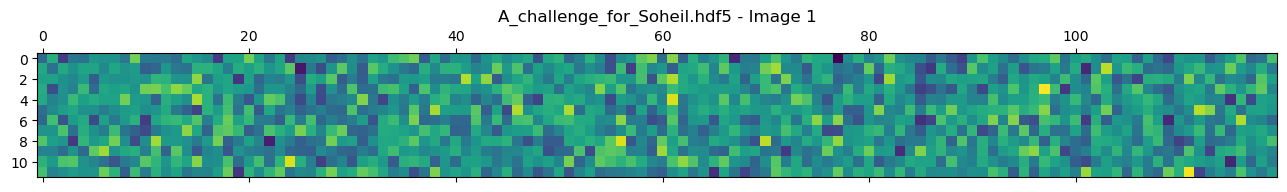

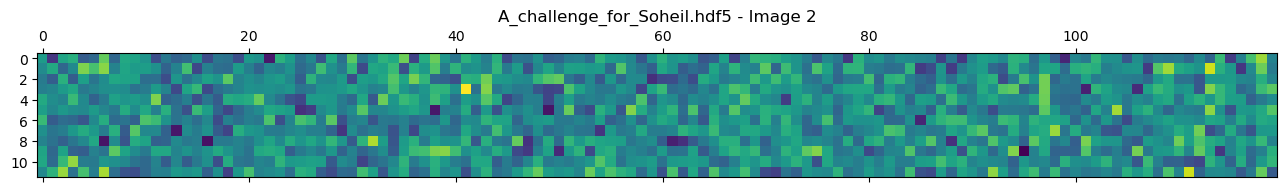

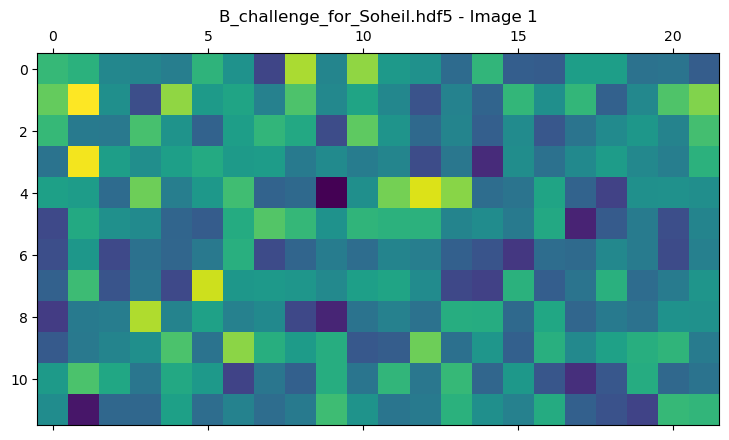

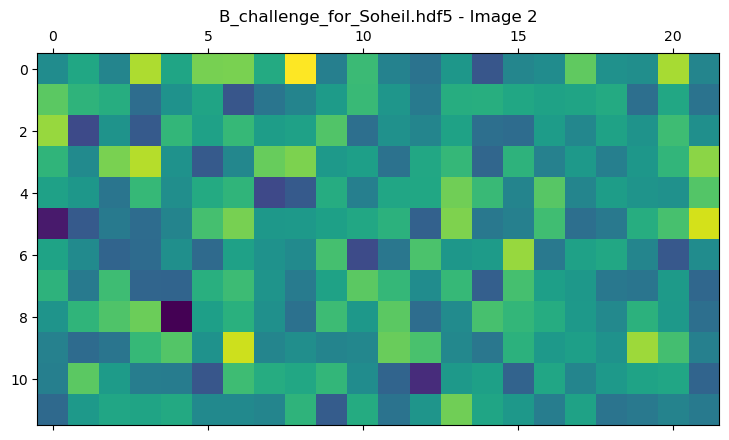


A challenge dimensions: (12, 120)
A challenge flattened image matrix shape: (3000, 1440)

B challenge dimensions: (12, 22)
B challenge flattened image matrix shape: (3000, 264)


In [11]:
datafilenameA='A_challenge_for_Soheil.hdf5'
datafilenameB='B_challenge_for_Soheil.hdf5'

height_A, width_A, flattened_A = process_and_plot_images(datafilenameA)
height_B, width_B, flattened_B = process_and_plot_images(datafilenameB)

print("\nA challenge dimensions:", (height_A, width_A))
print("A challenge flattened image matrix shape:", flattened_A.shape)

print("\nB challenge dimensions:", (height_B, width_B))
print("B challenge flattened image matrix shape:", flattened_B.shape)

# Step 2: Decide Between PCA and ICA  

As I know, PCA is good for data where the pixel intensities are more correlated and have smoother transitions. ICA is good for data where pixel intensities are more independent of each other.

I started by looking at the first 2 images from both challenges. In the A challenge, I noticed a little bit of smooth transition compared to the B challenge, where the images looked more random. But this observation was not enough to decide clearly.

I decided to plot the pixel intensity histograms to check if one of the datasets had a Gaussian shape and the other did not. If one was Gaussian, it would be good for PCA, and the non-Gaussian one would be better for ICA. But when I plotted the histograms, both challenges showed a Gaussian-like shape, so this method did not help me make a decision.

To get a better result, I looked for a numerical evaluation. I used two methods:  
1. The first method was the **mean spatial gradient (MSG)**, which calculates the average pixel gradient across the images. If the MSG is **high**, it means there are significant smooth changes and global patterns, which makes the data ideal for PCA. If the MSG is **low**, it means there are fewer smooth transitions and more local variations, which is better for ICA.  
2. The second method was **local variance**, which measures how independent or variable the pixel intensities are locally. If the variance is high, it indicates strong pixel correlations, favoring PCA. Low local variance suggests pixel independence, which is good for ICA.


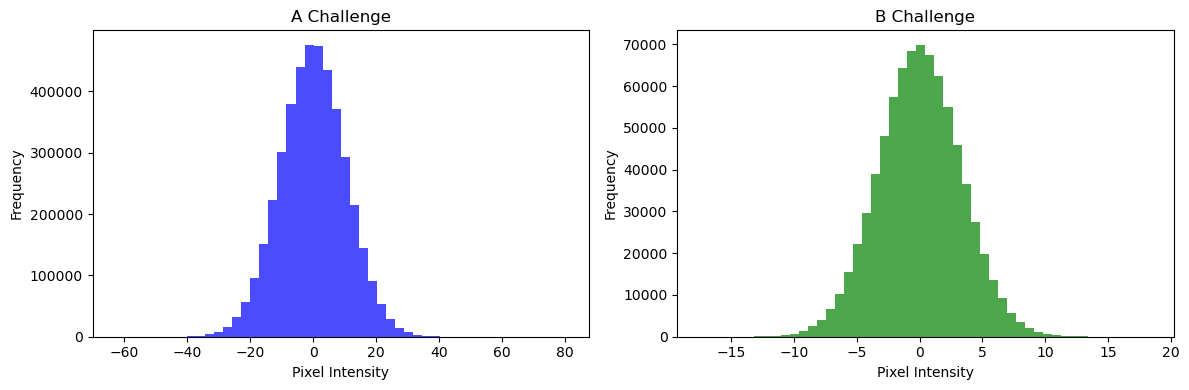

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot A challenge histogram
ax1.hist(flattened_A.flatten(), bins=50, color='blue', alpha=0.7)
ax1.set_title("A Challenge")
ax1.set_xlabel("Pixel Intensity")
ax1.set_ylabel("Frequency")

# Plot B challenge histogram
ax2.hist(flattened_B.flatten(), bins=50, color='green', alpha=0.7)
ax2.set_title("B Challenge")
ax2.set_xlabel("Pixel Intensity")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [24]:
# Function to compute mean spatial gradient (smoothness measure)
def compute_mean_spatial_gradient(flattened_images, image_height, image_width):
    gradients = []
    for image in flattened_images:
        reshaped_image = image.reshape(image_height, image_width)
        grad_x = sobel(reshaped_image, axis=0)
        grad_y = sobel(reshaped_image, axis=1)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        gradients.append(np.mean(gradient_magnitude))
    return np.mean(gradients)

# Function to compute mean local variance
def compute_mean_local_variance(flattened_images, image_height, image_width):
    local_variances = []
    for image in flattened_images:
        reshaped_image = image.reshape(image_height, image_width)
        local_variances.append(np.var(reshaped_image))
    return np.mean(local_variances)

# Compute metrics for A and B challenges
mean_gradient_A = compute_mean_spatial_gradient(flattened_A, height_A, width_A)
mean_local_variance_A = compute_mean_local_variance(flattened_A, height_A, width_A)

mean_gradient_B = compute_mean_spatial_gradient(flattened_B, height_B, width_B)
mean_local_variance_B = compute_mean_local_variance(flattened_B, height_B, width_B)

print("\nA Challenge:")
print(f"Mean Spatial Gradient: {mean_gradient_A:.2f}")
print(f"Mean Local Variance: {mean_local_variance_A:.2f}")

print("\nB Challenge:")
print(f"Mean Spatial Gradient: {mean_gradient_B:.2f}")
print(f"Mean Local Variance: {mean_local_variance_B:.2f}")


A Challenge:
Mean Spatial Gradient: 46.28
Mean Local Variance: 107.35

B Challenge:
Mean Spatial Gradient: 14.87
Mean Local Variance: 10.73


### **Analysis of Results:**

The **mean local variance (MLV)** of the A challenge is 107.35, which is very high, meaning the pixel intensities are highly correlated. This is ideal for **PCA**. The B challenge has a very low MLV of 10.73, indicating less correlation and more independence between pixels, which makes it good for **ICA**.

The **mean spatial gradient (MSG)** in the A challenge is 46.28, which is high, showing significant smooth changes and global patterns across the images. This is perfect for **PCA**. In contrast, the B challenge has a low MSG of 14.87, meaning fewer smooth transitions and more localized variations, which is better for **ICA**.

So, based on both metrics:
- **A challenge**: High MLV (107.35) and high MSG (46.28) → **Good for PCA**  
- **B challenge**: Low MLV (10.73) and low MSG (14.87) → **Good for ICA**

# Step 3: Apply PCA  
We will apply **PCA (Principal Component Analysis)** to reduce the dimensionality of the data and extract the most important patterns.  
Each **principal component** represents a distinct pattern or feature in the image dataset, which helps us identify the hidden characters.

We will also **highlight the most prominent regions** in each component using a threshold value (`highlight_threshold`). Regions with values higher than the threshold indicate areas where the component contributes strongly, making them good candidates for revealing characters.

<Figure size 800x400 with 0 Axes>

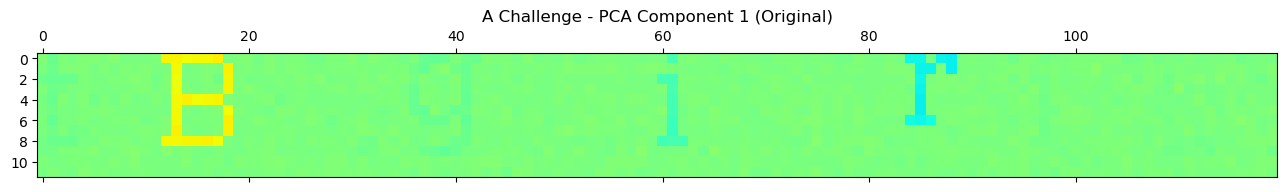

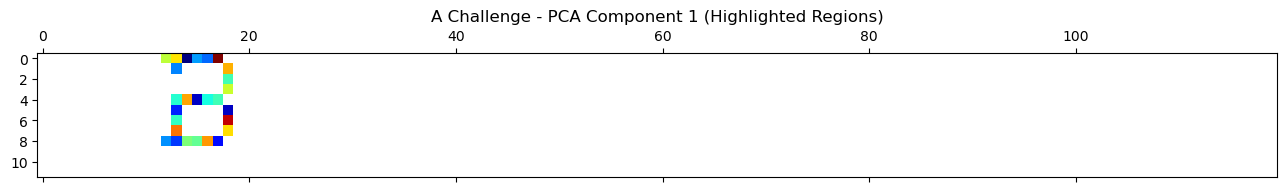

<Figure size 800x400 with 0 Axes>

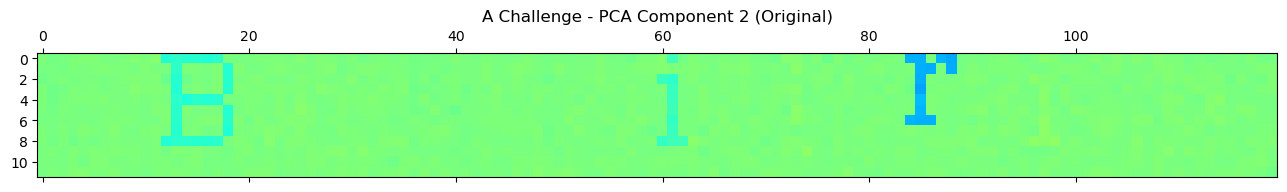

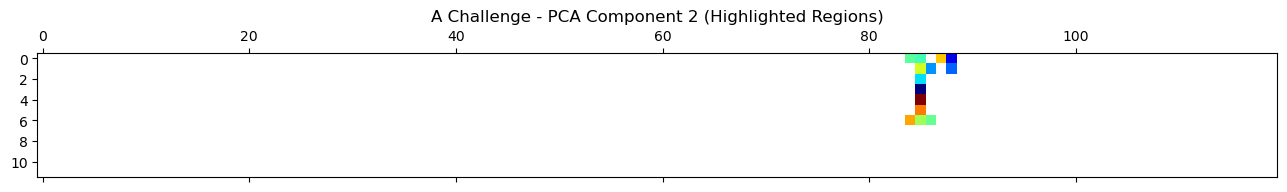

<Figure size 800x400 with 0 Axes>

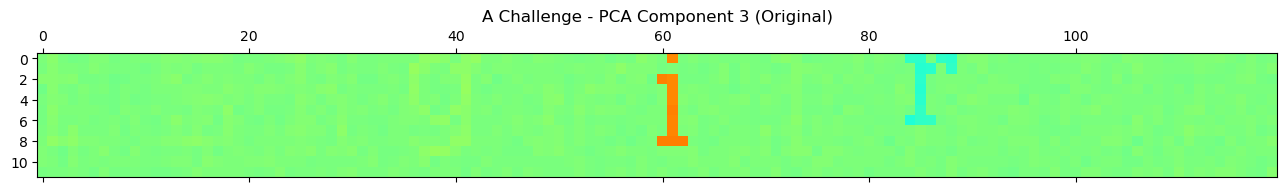

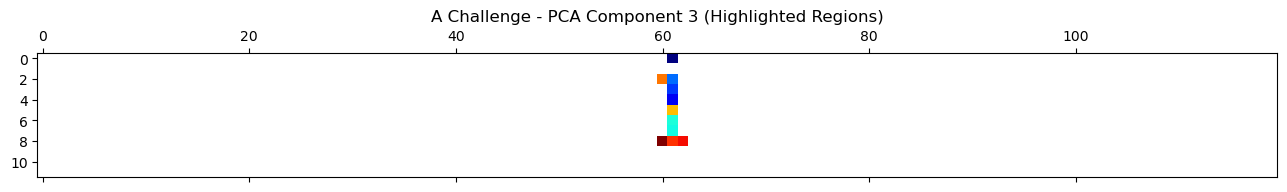

<Figure size 800x400 with 0 Axes>

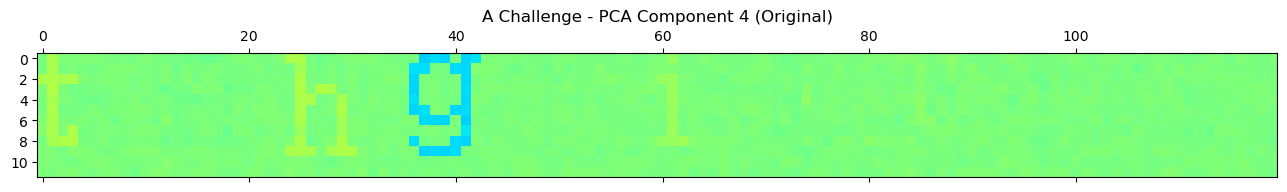

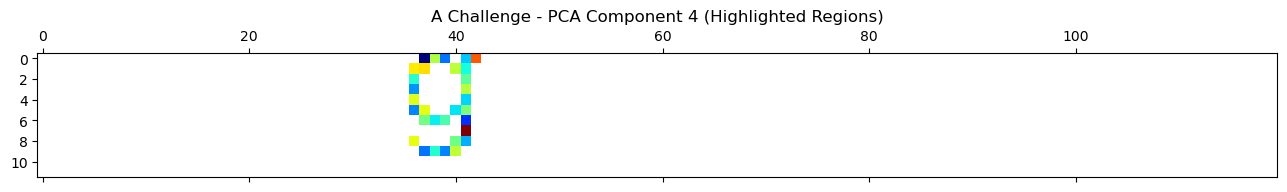

<Figure size 800x400 with 0 Axes>

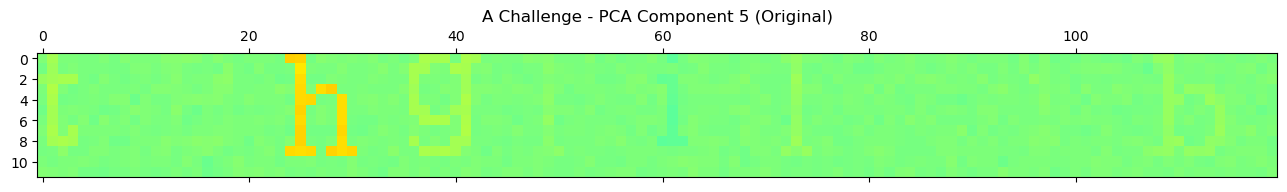

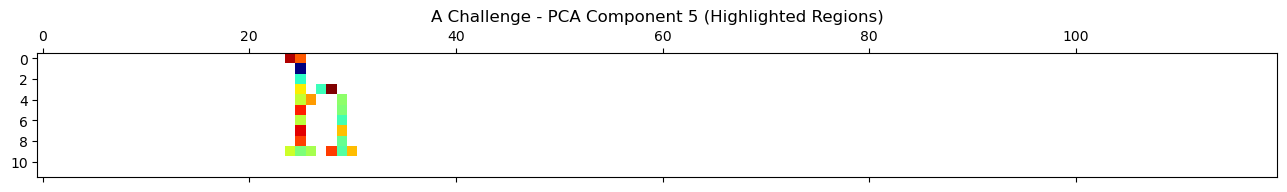

<Figure size 800x400 with 0 Axes>

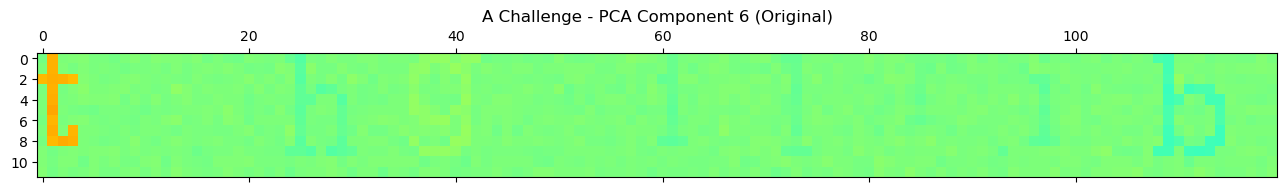

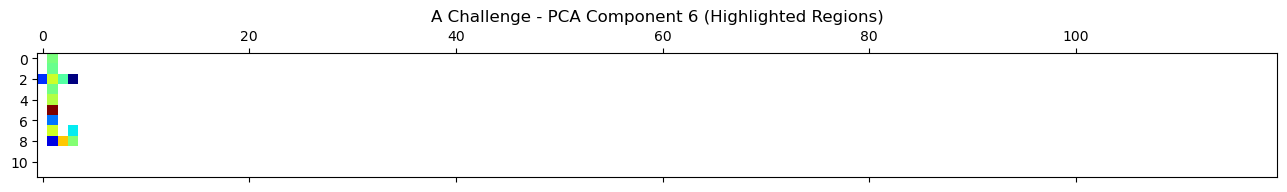

<Figure size 800x400 with 0 Axes>

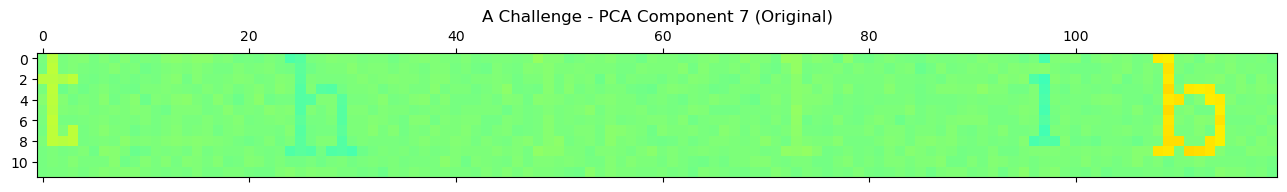

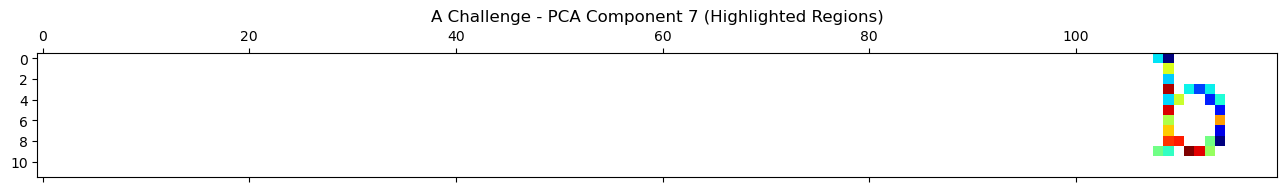

<Figure size 800x400 with 0 Axes>

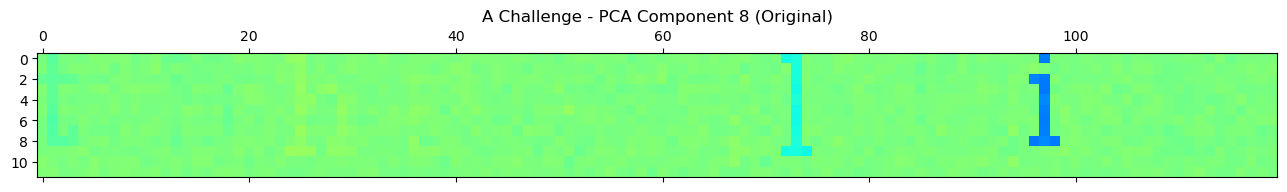

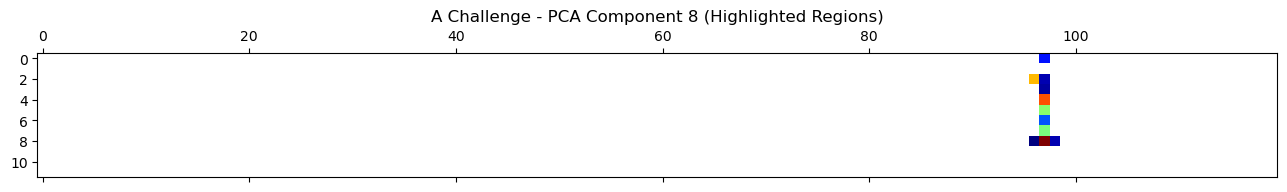

<Figure size 800x400 with 0 Axes>

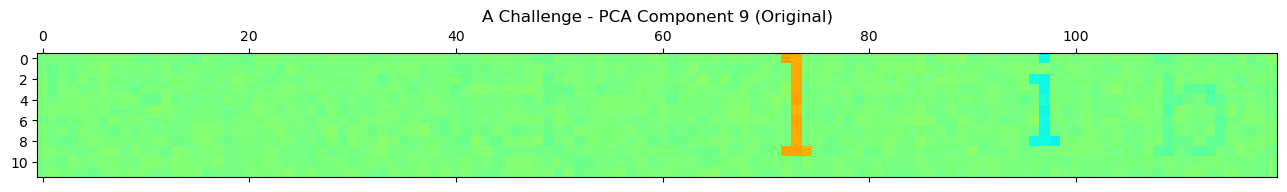

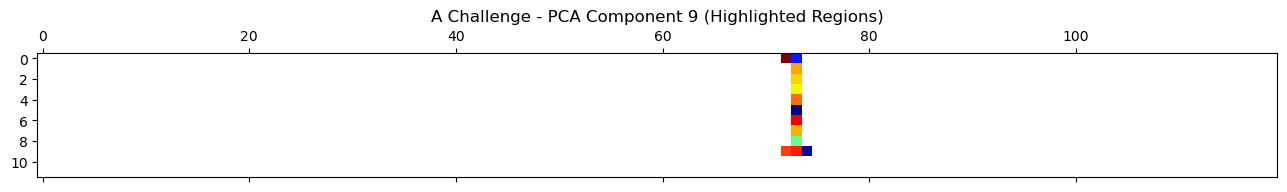

<Figure size 800x400 with 0 Axes>

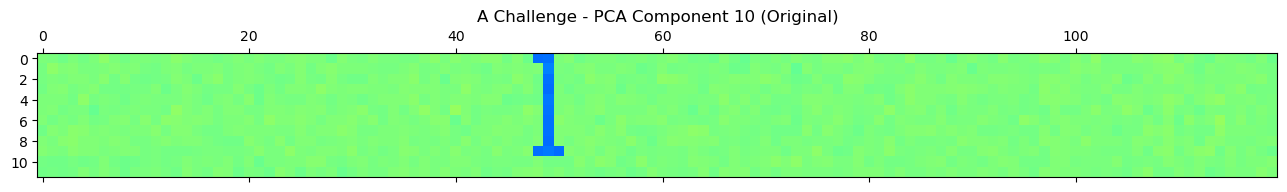

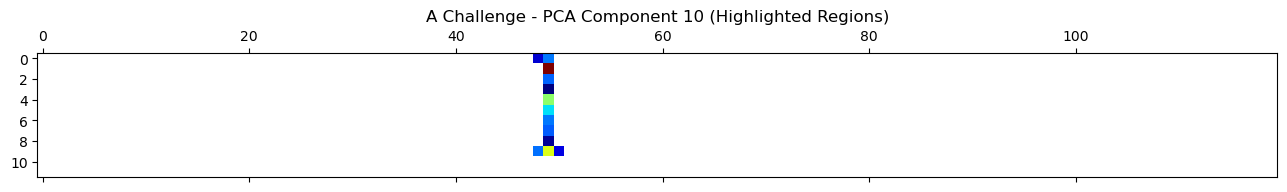

In [38]:
# Apply PCA with 10 components
pca = PCA(n_components=10)
pca_result_A = pca.fit(flattened_A)
pca_components_A = pca.components_

# Set the threshold to highlight prominent regions
highlight_threshold = 0.14 

for i in range(10):
    component_image = pca_components_A[i].reshape(height_A, width_A)
    
    mask = np.abs(component_image) > highlight_threshold
    
    plt.figure(figsize=(8, 4))
    
    plt.matshow(component_image, cmap=cm.jet, interpolation='nearest', vmin=-0.5, vmax=0.5)
    plt.title(f"A Challenge - PCA Component {i+1} (Original)")
    plt.show()

    plt.matshow(np.where(mask, component_image, np.nan), cmap=cm.jet, interpolation='nearest')
    plt.title(f"A Challenge - PCA Component {i+1} (Highlighted Regions)")
    plt.show()

# Step 4: Apply ICA  
We will apply **ICA (Independent Component Analysis)** to extract statistically independent components from the dataset.  
Unlike PCA, which focuses on variance and correlation, **ICA is designed to separate independent signals** that may be hidden in the data.  
This makes ICA particularly useful for detecting independent patterns like letters or symbols in the dataset.

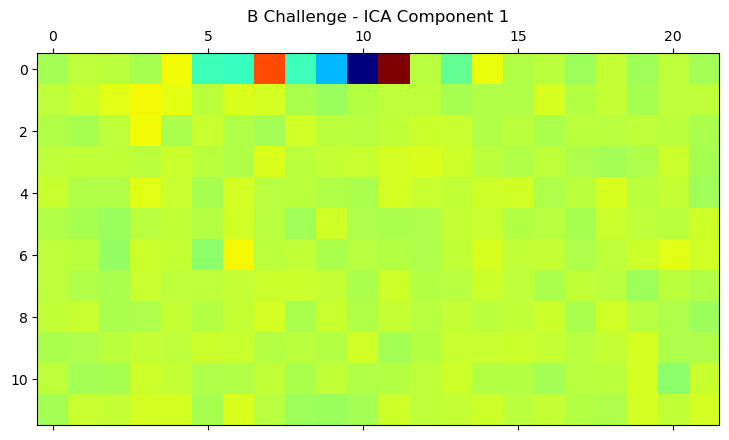

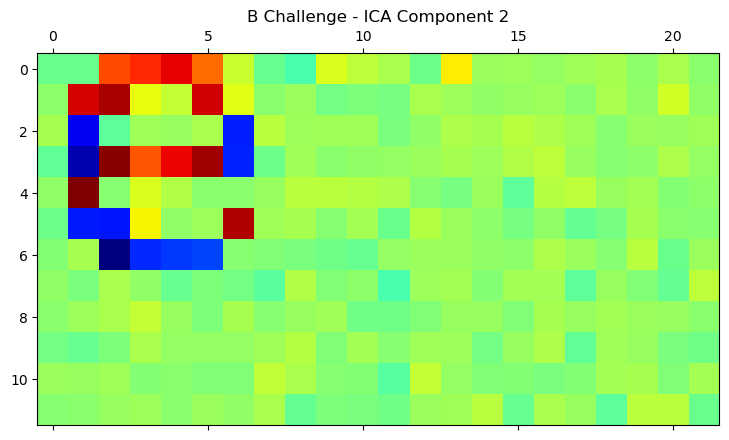

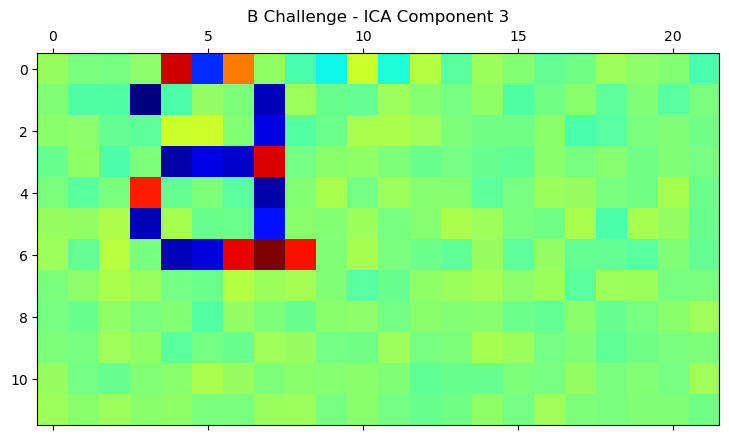

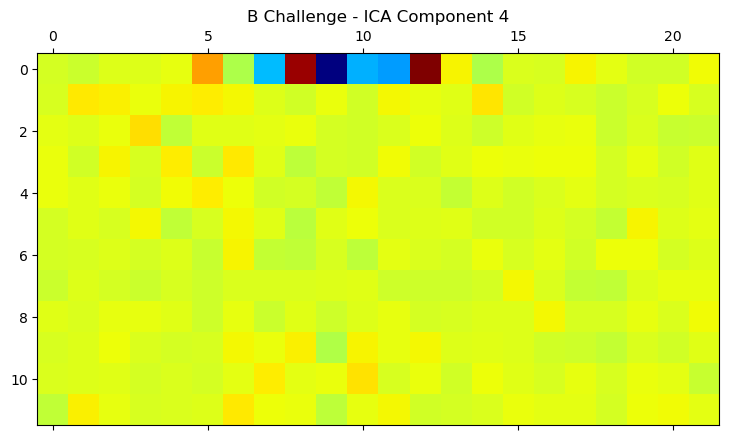

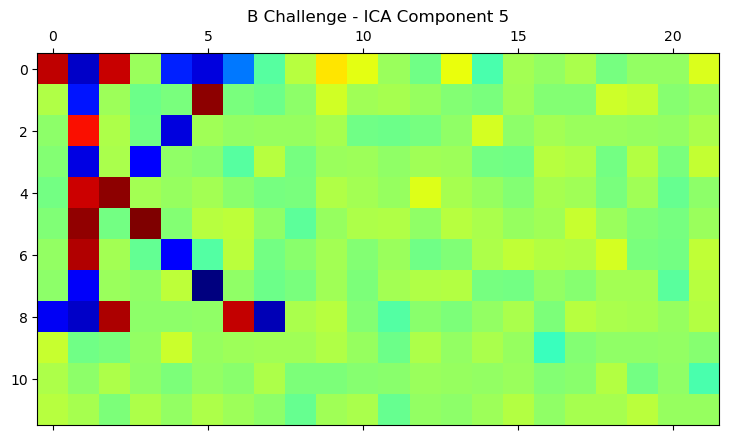

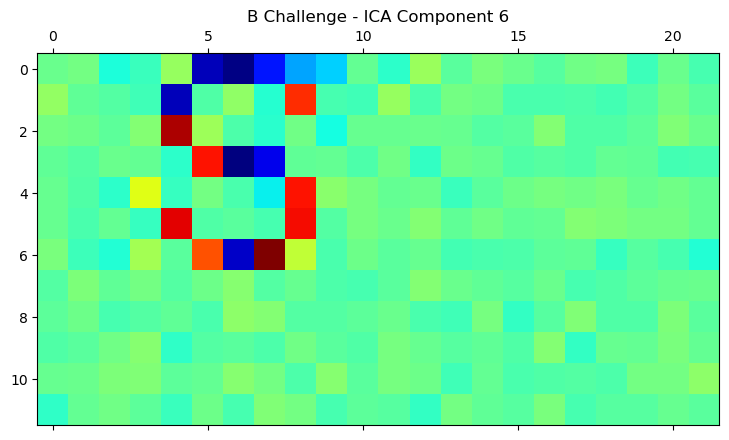

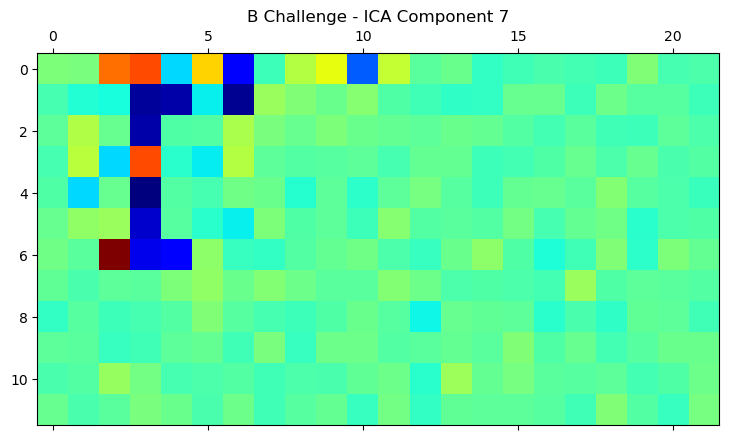

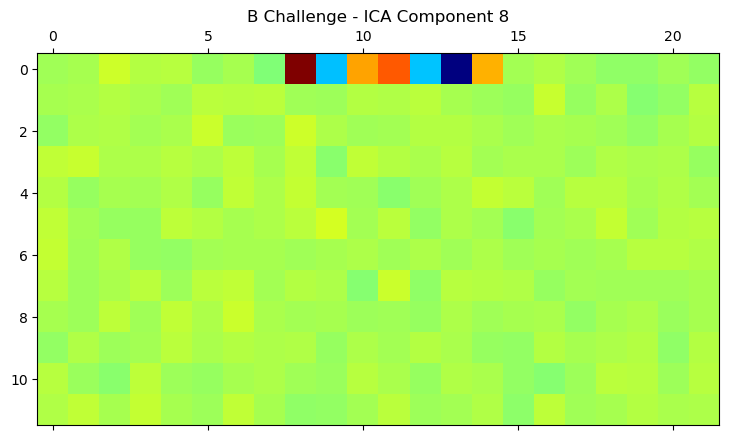

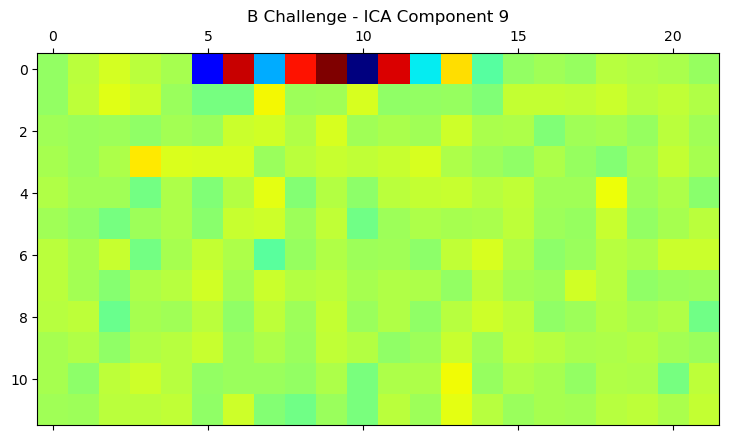

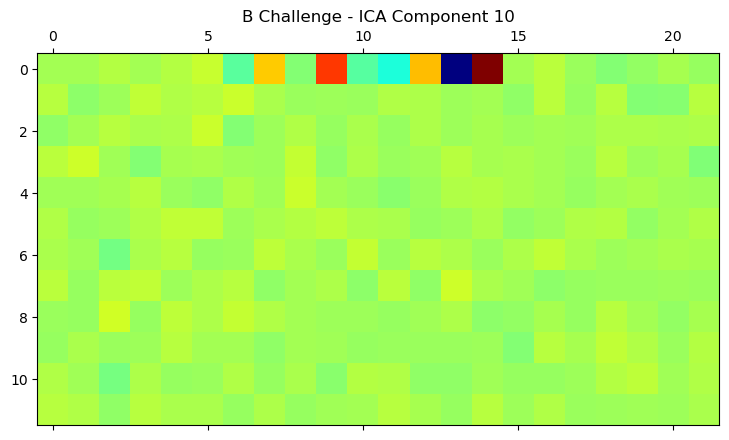

In [26]:
# Apply ICA with 10 components
ica = FastICA(n_components=10)
ica_result_B = ica.fit(flattened_B)
ica_components_B = ica.components_

for i in range(10):
    plt.matshow(ica_components_B[i].reshape(height_B, width_B), interpolation='nearest', cmap=cm.jet)
    plt.title(f"B Challenge - ICA Component {i+1}")
    plt.show()

# Step 7: Extract and Interpret the Hidden Words  

We will interpret the components obtained from **PCA (A challenge)** and **ICA (B challenge)** to find the hidden letters and words.  

### **How to Interpret the Components:**
- **PCA (A challenge):**  
  The letters are revealed based on the brightness of regions within the PCA components.  
  The brightest regions correspond to characters.  
- **ICA (B challenge):**  
  The letters are revealed by reading the components from **left to right**.  
  ICA is designed to separate independent signals, making it easier to detect characters.

---

## **PCA Challenge (A file)**  
- **Letters Found:** 'B', 'r', 'i', 't', 'h', 'b', 'i', 'l', 'l'  
- **Hidden Word:** Brightbill  

## **ICA Challenge (B file)**  
- **Letters Found:** 's', 'a', 'e', 'K', 'r'  
- **Hidden Word:** Keras  

---
  
PCA highlights the correlated regions to reveal the hidden word **Brightbill**, while ICA separates independent signals to reveal **Keras**.